In [1]:
# Add project src to path.
import set_path
import glob

# Import modules.
import numpy as np
import time
import logging
from tqdm import tqdm

# Visulatisation
#%matplotlib widget
import matplotlib.pyplot as plt

import set_path
import src.utils.ahn_utils as ahn_utils
import src.utils.las_utils as las_utils
import src.utils.plot_utils as plot_utils
import src.utils.clip_utils as clip_utils
import src.utils.math_utils as math_utils
import src.utils.bgt_utils as bgt_utils

from src.utils.interpolation import FastGridInterpolator

from pyntcloud import PyntCloud
import pandas as pd
from skimage import feature
from scipy import ndimage
import cv2 as cv
import pyransac3d as pyrsc

import open3d as o3d
from shapely.geometry import LineString, Point
from shapely.ops import nearest_points
import shapely 
from scipy.optimize import curve_fit
import scipy.spatial

from multiprocessing import Pool
from sklearn.cluster import DBSCAN

from skimage.transform import probabilistic_hough_line, hough_line, hough_line_peaks
from src.region_growing.label_connected_comp import LabelConnectedComp

from sklearn.metrics import classification_report

## Methods

In [2]:
def plot_cloud(points, labels, plot_3d=True, legend=True, aspect=5):

    fig = plt.figure()
    if plot_3d:
        ax = plt.axes(projection='3d')
        for label in np.unique(labels):
            mask = labels == label
            ax.scatter(points[mask][:,0],points[mask][:,1],points[mask][:,2], s=2, label=str(label))
        ax.set_zlim((0,12))
        if aspect:
            centers = points.min(axis=0) + ((points.max(axis=0) - points.min(axis=0)) / 2)
            ax.set_xlim((centers[0]-aspect,centers[0]+aspect))
            ax.set_ylim((centers[1]-aspect,centers[1]+aspect))

    else:
        ax = plt.axes()
        for label in np.unique(labels):
            mask = labels == label
            ax.scatter(points[mask][:,0],points[mask][:,1], s=1,label=str(label))
    if legend:
        plt.legend()
    plt.show()

In [3]:
def sample_cable(points, true_labels, sample_size=0.8):
    if sample_size == 1:
        return true_labels == 15
    else:
        cable_ids = np.where(true_labels==15)[0]
        cable_sample_ids = np.random.choice(cable_ids, int(len(cable_ids)*(1-sample_size)), replace=False)
        sample_labels = true_labels.copy()
        sample_labels[cable_sample_ids] = 0
        cable_mask = sample_labels == 15

        return cable_mask

In [4]:
def main_direction(points):
    """ Returns the eigenvector corresponding to the largest eigenvalue of `points`"""
    cov = np.cov(points, rowvar=False)
    eig_val, eig_vec = np.linalg.eig(cov)
    dir_v = eig_vec[:,eig_val.argmax()]
    if dir_v[0] < 0:
        dir_v *= -1
    return dir_v

def unit_vector(v1):
    """ Returns the unit vector of `v1`"""
    return v1 / np.linalg.norm(v1)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'"""
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.rad2deg(np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)))

def cable_cut(points, mask):
    """Create a new axis along the direction of a cable. Cable start is 0"""
    cable_dir = main_direction(points[mask][:,:2])
    cable_dir_axis = np.dot(points[:,:2], cable_dir)
    cable_dir_axis -= cable_dir_axis[mask].min()
    return cable_dir_axis

def linestring_cable_fit(points, cable_axis, binwidth_z=.75, binwidth_axis=.5):
    """
    Returns linetring fits for both z and xy projections.

    Parameters
    ----------
    points : array of shape (n_points, 3)
        The point cloud <x, y, z>.
    cable_axis : array of shape (n_points,)
        The cable directional axis values <d>.
    binwidth_z : float (default .75)
        The bindwithd used to calculate the statistic over.
    binwidth_axis : float (default .5)
        The bindwithd used to calculate the statistic over.

    Returns
    -------
    cable_zline : LineString
        linestring fit on Z axis projection.
    cable_axisline : LineString
        linestring fit on XY projection.
    """

    cable_max = cable_axis.max()
    
    # LineString fit Z projection
    bins = np.linspace(0 - (binwidth_z/2), cable_max + (binwidth_z/2), int(round(cable_max/binwidth_z)+2))
    mean_z, bin_edges, _ = scipy.stats.binned_statistic(cable_axis, points[:, 2], statistic='mean', bins=bins)
    x_coords = (bin_edges[:-1] + bin_edges[1:]) / 2
    line_pts = np.vstack((x_coords, mean_z)).T
    line_pts = line_pts[~np.isnan(line_pts).any(axis=1)]
    cable_zline = shapely.geometry.LineString(line_pts)

    # LineString fit XY projection
    bins = np.linspace(0 - (binwidth_axis/2), cable_max + (binwidth_axis/2), int(round(cable_max/binwidth_axis)+2))
    mean_x, _, _ = scipy.stats.binned_statistic(cable_axis, points[:, 0], statistic='mean', bins=bins)
    mean_y, _, _ = scipy.stats.binned_statistic(cable_axis, points[:, 1], statistic='mean', bins=bins)
    line_pts = np.vstack((mean_x, mean_y)).T
    line_pts = line_pts[~np.isnan(line_pts).any(axis=1)]
    cable_axisline = shapely.geometry.LineString(line_pts)

    return cable_zline, cable_axisline

def cable_fit(points, cable_mask, radius_h=.07, radius_w=.1, binwidth_z=.75, binwidth_axis=.5, refit=True):
    """
    Returns the label mask for the re-fitted cable.

    Parameters
    ----------
    points : array of shape (n_points, 3)
        The point cloud <x, y, z>.
    cable_mask : array of shape (n_points,) with dtype=bool
        Pre-mask used as labelled cable points.
    radius : float (default .07)
        Cable radius used for clipping points
    z_binwidth : float (default .75)
        The binwidth to average cable z for.
    axis_binwidth : float (default .5)
        The binwidth to average cable x,y for.

    Returns
    -------
    An array of shape (n_points,) with dtype=bool indicating which points
    should be labelled as cable points.
    """

    # Calculate directional axis
    cable_axis = cable_cut(points, cable_mask)
    dir_points = np.vstack([cable_axis,points[:,2]]).T
    cable_zline, cable_axisline = linestring_cable_fit(points[cable_mask], cable_axis[cable_mask], binwidth_z, binwidth_axis)

    # Estimate clip mask for cable points 
    if refit:
        h_mask = clip_utils.poly_clip(dir_points, cable_zline.buffer(radius_h)) # Analysis showed 20cm diameter
        axis_mask = clip_utils.poly_clip(points, cable_axisline.buffer(radius_w))
        cable_mask = h_mask & axis_mask
        cable_axis = cable_cut(points, cable_mask)
        cable_zline, cable_axisline = linestring_cable_fit(points[cable_mask], cable_axis[cable_mask], binwidth_z, binwidth_axis)

    return cable_mask, cable_axis, cable_zline, cable_axisline

def clip_cable_area(points, cable_axis, cable_zline, cable_axisline, h_buffer=0.5, w_buffer=.5):

    # Height clip
    cable_zpoly = cable_zline.buffer(h_buffer)
    dir_points = np.vstack((cable_axis, points[:,2])).T
    height_mask = clip_utils.poly_clip(dir_points, cable_zpoly)

    # Direction clip
    cable_axispoly = cable_axisline.buffer(w_buffer)
    axis_mask = clip_utils.poly_clip(points[:,:2], cable_axispoly)

    # Clip
    mask = height_mask & axis_mask

    return mask

def cable_angle(cable_zline, bin_dist=3, plot=False):

    coords = np.asarray(cable_zline.coords)
    no_ = len(coords)
    angles = np.zeros(no_)
    if no_ > 2 * bin_dist:
        for i in range(bin_dist, no_ - bin_dist):
            v_a = coords[i] - coords[i - bin_dist]
            v_b = coords[i + bin_dist] - coords[i]
            angle = angle_between(v_a, v_b)
            if angle > 2 and v_a[1] < v_b[1]:
                angles[i] = 1 #angle

    if plot:
        fig = plt.figure(figsize=(16,6)) 
        ax = plt.axes()
        ax.plot(*cable_zline.xy, c='red')
        ax2 = ax.twinx()
        ax2.bar(coords[:,0], angles, 0.15, color='red')
        ax2.set_ylim((0,10))

    return np.vstack([coords[:,0],angles]).T

In [5]:
def _has_decoration(points, cable_mask, cable_axis, cable_zline, cable_axisline, threshold=.5, width_buffer=.2, plot=False):

    # create cable bottom polygon
    search_height = 1 # TODO: parameter analysis
    cable_radius = 0.1 # TODO: parameter analysis (we use different radius?)
    top_coords = np.array(cable_zline.coords) - [0, cable_radius]
    bottom_coords = np.array(cable_zline.coords) - [0, cable_radius + search_height]
    clip_poly = shapely.geometry.Polygon([*top_coords, *bottom_coords[::-1]])
    dir_points = np.vstack((cable_axis, points[:,2])).T
    
    # decoration clip
    # TODO: Pre clip with min Z and max Z? poly_clip is comp.exp.
    mask = np.all([
        ~cable_mask,
        clip_utils.poly_clip(points[:,:2], cable_axisline.buffer(width_buffer)), # optional to make have smaller width buffer
        clip_utils.poly_clip(dir_points, clip_poly), # clip points under the line
        cable_axis > .25, 
        cable_axis < cable_axis[cable_mask].max() - .25
        ], axis=0)

    if mask.sum() == 0:
        return False

    # density analysis
    res = scipy.stats.binned_statistic(cable_axis[mask], np.ones(mask.sum()), statistic='count', bins=np.arange(0.25, cable_axis[cable_mask].max()-.25, 0.2)) # TODO: right margins
    pt_threshold = 10
    bin_density = res.statistic > pt_threshold
    cable_density_per = bin_density.sum() / len(bin_density)
    result = cable_density_per > threshold

    if plot:
        ax1 = plt.subplot()
        ax1.set_title('Decoration Analysis')
        ax1.set_xlabel('x (meter)')
        ax1.set_ylabel('height (meter)')
        ax1.scatter(cable_axis[mask], points[mask][:,2], s=1, c='blue')
        ax1.scatter(cable_axis[cable_mask], points[cable_mask][:,2], s=1, c='gray')

        fig = plt.figure()
        ax =  plt.axes()
        ax.set_title('Decoration Analysis')
        bin_xs = (res.bin_edges[1:] + res.bin_edges[:-1]) / 2
        ax.bar(bin_xs, res.statistic, 0.2)
        ax.set_ylabel('bin point count')
        ax.set_xlabel('x (meter)')
        #bin_xs = (res.bin_edges[1:] + res.bin_edges[:-1]) / 2
        #ax2 = ax1.twinx()
        #ax2.plot(bin_xs, res.statistic, c='k')
        
    return result

In [25]:
def segmentation_plot(points, cable_axis, segmentation, filter_mask, cable_yline):

    # Plot clusters
    fig = plt.figure()
    ax = plt.axes()
    for cluster in np.unique(segmentation.labels_):
        c_mask = segmentation.labels_ == cluster
        ax.scatter(cable_axis[filter_mask][c_mask], points[filter_mask][c_mask][:,2], s=1)
        ax.scatter(cable_axis[filter_mask][c_mask].mean(), points[filter_mask][c_mask][:,2].mean(), c='k')
    #ax.scatter(cable_axis[filter_mask], points[filter_mask][:,2], s=1)
    ax.scatter(cable_axis[~filter_mask], points[~filter_mask][:,2], s=1, c='gray')

    yline = np.array(cable_yline.coords)
    ax.plot(yline[:,0], yline[:,1], c='k')

    ax.set_ylim((points[:,2].min()-1,points[:,2].max()+1))

def _is_armatuur(props, cable_angles):

    # Check conditions (1. cluster dimensions & 2. centroid should be under cable)
    props['width_dim_condition'] =  .25 < props['width'] < 1.25
    props['height_dim_condition'] = .25 < props['height'] < .6
    props['z_offset'] = 0 < props['z_offset'] < .55
    props['axis_offset'] = props['axis_offset'] < 0.1
    props['cable_bending'] = bool(cable_angles[np.abs(props['axis_pos'] - cable_angles[:,0]).argmin(), 1])

    return props

def cluster_properties(points, cable_axis, cable_zline, cable_axisline):
    
    # cluster props
    props = {}

    # Cluster dimension
    props['width'] = cable_axis.max() - cable_axis.min()
    props['height'] = points[:,2].max() - points[:,2].min()
    props['centroid'] = points.mean(axis=0)

    # Cluster position offset
    props['axis_pos'] = cable_axis.mean() # TODO: change to middle?
    props['z_offset'] = nearest_points(cable_zline, Point([props['axis_pos'], props['centroid'][2]]))[0].y - props['centroid'][2]
    props['axis_offset'] = LineString(nearest_points(cable_axisline, Point(props['centroid'][:2]))).length

    return props


In [26]:
def armatuur_extractor_lcc(points, cable_mask, cable_axis, cable_zline, cable_axisline, plot=False):

    # 0. create mask
    armatuur_mask = np.zeros(len(points), dtype=bool)
    armatuur_labels = np.zeros(len(points))

    # 1. Clip search-area
    clip_mask = clip_cable_area(points, cable_axis, cable_zline, cable_axisline, 1, .5)

    # 2. LabelConnectedComponents
    mask = clip_mask & ~cable_mask
    lcc = LabelConnectedComp(label=-1, grid_size=0.07,
                            min_component_size=20)
    point_components = lcc.get_components(points[mask])
    

    # 3. Cluster analysis for armatuur
    cc_tags = {}
    cc_labels = set(np.unique(point_components)).difference((-1,0))
    if len(cc_labels) > 0:
        cable_angles = cable_angle(cable_zline)

        for cc in cc_labels:
            cc_mask = (point_components == cc)
            cc_props = cluster_properties(points[mask][cc_mask], cable_axis[mask][cc_mask], cable_zline, cable_axisline)
            cc_props = _is_armatuur(cc_props, cable_angles)
            cc_tags[cc] = cc_props
            armatuur_labels[np.where(mask)[0][cc_mask]] = cc
            armatuur_mask[np.where(mask)[0][cc_mask]] = np.all(list(cc_props.values())[-5:-1])

            if plot:
                plot_cloud(points[mask][cc_mask], armatuur_labels[mask][cc_mask], aspect=1)

    #if plot:
        #plot_cloud(points[clip_mask], armatuur_labels[clip_mask])
        
    return armatuur_mask, armatuur_labels, cc_tags

precision    0.999613
recall       0.995698
f1-score     0.997621
dtype: float64

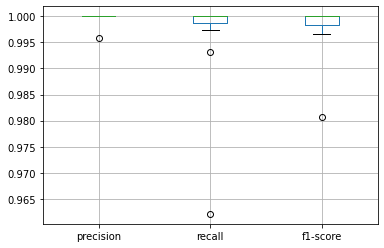

In [28]:
sample_size = 1
results = []

#for las_file in ['../datasets/suspended_light_cables/sample2.laz']: #5
for las_file in glob.iglob('../datasets/suspended_light_cables/*.laz'):

    #print('\nprocessing: ', las_file)
    # Load pointcloud
    pointcloud = las_utils.read_las(las_file)
    true_labels = pointcloud.label
    true_labels[~((true_labels == 15) | (true_labels == 14))] = 0
    points = np.vstack((pointcloud.x, pointcloud.y, pointcloud.z)).T

    # Create predictions
    labels_pred = np.zeros(len(true_labels))

    # Sample cable mask?
    sample_size = 1
    cable_mask = sample_cable(points, true_labels, sample_size)

    # Cable line fit
    cable_mask, cable_axis, cable_zline, cable_axisline = cable_fit(points, cable_mask, refit=False)
    #plot_cloud(points[:, :2], cable_mask, plot_3d=False, aspect=1)
    labels_pred[cable_mask] = 15

    # Decoration check
    if not _has_decoration(points, cable_mask, cable_axis, cable_zline, cable_axisline):
        armatuur_mask, armatuur_labels, cc_tags = armatuur_extractor_lcc(points, cable_mask, cable_axis, cable_zline, cable_axisline, plot=False)
        labels_pred[armatuur_mask] = 14

    report = classification_report(true_labels, labels_pred, labels=[0,14,15], target_names=['unclassified', 'armatuur', 'cable'], output_dict=True, zero_division=1)['armatuur']
    results.append(report)
    #print('processing: ', las_file, report)

df = pd.DataFrame(results)[['precision','recall','f1-score']]
df.boxplot()
df.mean()

## Approach: PRJ

In [9]:
def projection_filter(points, cable_axis, plot=True, num_dil=3):

    # Project
    grid, _, _, binnumber = scipy.stats.binned_statistic_2d(cable_axis, points[:,2], np.ones(len(points)), statistic='count', bins=[np.arange(cable_axis.min(), cable_axis.max(), 0.05), np.arange(points[:,2].min(), points[:,2].max(), 0.05)], expand_binnumbers=True)
    grid_shape = np.array(grid.shape) + 1
    binindices = np.ravel_multi_index(binnumber-1, grid_shape)

    # Image filters
    grid = np.where(grid>0, True, False)
    grid_1 = ndimage.binary_fill_holes(grid)
    grid_2 = ndimage.binary_erosion(grid_1, iterations=2)
    grid_3 = ndimage.binary_dilation(grid_2, iterations=num_dil)

    if plot:
        fig, ax = plt.subplots(4,1, sharex=True)
        ax[0].set_title('Projection Filters')
        ax[0].imshow(grid.T, cmap = 'gray')
        ax[1].imshow(grid_1.T, cmap = 'gray')
        ax[2].imshow(grid_2.T, cmap = 'gray')
        ax[3].imshow(grid_3.T, cmap = 'gray')
        ax[0].invert_yaxis()
        ax[1].invert_yaxis()
        ax[2].invert_yaxis()
        ax[3].invert_yaxis()

    # convert 2d back to 3d mask
    multi_index = np.array(np.where(grid_3>0))
    residual_bins = np.ravel_multi_index(multi_index, grid_shape)
    residual_mask = np.isin(binindices, residual_bins)

    return residual_mask

def armatuur_extractor_prj(points, cable_mask, true_labels, plot=False):
    """
    More robust method if not all cable points are found.
    """

    # 0. create mask
    armatuur_mask = np.zeros(len(points), dtype=bool)
    label_mask = np.zeros(len(points))
    label_mask[true_labels==15] = 15

    # 1. Clip search-area
    cable_axis = cable_cut(points, cable_mask)
    clip_mask, cable_yline, cable_axisline = clip_cable_area(points, cable_mask, cable_axis)
    
    # 3. Check for decoration
    decoration_cable = _has_decoration(points[clip_mask], cable_mask[clip_mask], cable_axis[clip_mask], cable_axisline, cable_yline, plot)
    if not decoration_cable:

        # 4. Projection
        filter_mask = projection_filter(points[clip_mask], cable_axis[clip_mask], plot, 5)

        # 5. ConnectedComponents
        filter_mask = ~cable_mask[np.where(clip_mask)[0]] & filter_mask
        lcc = LabelConnectedComp(grid_size=0.1, min_component_size=40)
        point_components = lcc.get_components(points[clip_mask][filter_mask])
        cc_labels = np.unique(point_components)

        if plot:
            
            fig, ax = plt.subplots(1,len(set(cc_labels).difference((-1,))), figsize=(12,4))
            i=0
            for cc in set(cc_labels).difference((-1,)):
                cc_mask = (point_components == cc)
                cc_pts = points[clip_mask][filter_mask][cc_mask][:,2]
                cc_axis_pts = cable_axis[clip_mask][filter_mask][cc_mask]

                ax[i].scatter(cc_axis_pts, cc_pts, s=1)
                ax[i].scatter(cable_axis[cable_mask], points[cable_mask][:,2], s=1, c='k')
                m_ax = cc_axis_pts.min() + (cc_axis_pts.max()-cc_axis_pts.min())/2
                m_y = cc_pts.min() + (cc_pts.max()-cc_pts.min())/2
                

                bbox = math_utils.compute_bounding_box(np.vstack([cc_axis_pts,cc_pts]).T)
                dims = [round(bbox[2]-bbox[0],2), round(bbox[3]-bbox[1],2)]

                ploy = shapely.geometry.box(*bbox)
                ax[i].plot(*ploy.exterior.xy)
                margin = np.max(dims)/2 + 0.2
                ax[i].set_xlim((m_ax-margin, m_ax+margin))
                ax[i].set_ylim((m_y-margin, m_y+margin))
                ax[i].set_title(dims)
                i+=1

        # 6. Cluster analysis for armatuur
        cc_count = 0
        for cc in set(cc_labels).difference((-1,)):
            # select points that belong to the cluster
            cc_mask = (point_components == cc)
            cc_pts = points[clip_mask][filter_mask][cc_mask]
            cc_axis_pts = cable_axis[clip_mask][filter_mask][cc_mask]
            valid, record = _is_armatuur(cc_pts, cc_axis_pts, cable_yline, cable_axisline)
            if plot:
                print(cc, valid, record)
            if valid:
                armatuur_mask[np.where(clip_mask)[0][filter_mask][cc_mask]] = valid

    if plot:
        plot_cloud(points[clip_mask], armatuur_mask[clip_mask])

    return armatuur_mask, clip_mask


## Analysis

In [1]:
import itertools

In [ ]:
def cable_fit_analysis(filepaths, params):
    # filepaths = 
    # param = [sample_size, radius_h, radius_w, binwidth_z, binwidth_axis]

    records = []

    for las_file in filepaths:

        # Load pointcloud
        pointcloud = las_utils.read_las(las_file)
        points = np.vstack((pointcloud.x, pointcloud.y, pointcloud.z)).T
        true_labels = np.zeros(len(points))
        true_labels[pointcloud.label==15] = 15

        for param in params:

            # Sample cable from GT
            cable_mask = sample_cable(points, true_labels, param[1])

            # Cable refit
            label_mask, _, _, _ = cable_fit(points, cable_mask, radius_h=param[1], radius_w=param[2], binwidth_z=param[3], binwidth_axis=param[4], refit=False)

            pred_labels = np.zeros(len(points))
            pred_labels[label_mask] = 15

            report = classification_report(true_labels, pred_labels, labels=[0,15], target_names=['unclassified', 'cable'], output_dict=True, zero_division=1)['cable']
            record = param + [report['precision'], report['recall'], report['f1-score']]
            records.append(record)

    df = pd.DataFrame(reports, columns=['sample_size', 'radius_h', 'radius_w', 'binwidth_z', 'binwidth_axis', 'precision', 'recall', 'f1-score'])

    return df

In [ ]:
# Params to explore
sample_sizes = [1]
radius_hs = [.07]
radius_ws = [.1]
binwidth_zs = [.75]
binwidth_axiss = [.5]
params = itertools.product(*[sample_sizes, radius_hs, radius_ws, binwidth_zs, binwidth_axiss])

# Files to analyse
filepaths = glob.iglob('../datasets/suspended_light_cables/*.laz')

results = cable_fit_analysis(filepaths, params)

In [48]:



rows= [] 
for r in np.arange(0.07, 0.11,0.01):
    for z in np.arange(.5, 1.25, 0.25):
        for d in [0.5]:
            row = run(r, z, d)
            rows.append([r,z,d,*row])
    print(r)
df = pd.DataFrame(rows, columns=['r','z','d','precision', 'recall', 'f1-score', 'support'])

df.sort_values('f1-score', ascending=False)

,r,z,d,precision,recall,f1-score,support
1,0.07,0.75,0.5,0.965327,0.969963,0.964886,1437.222222
4,0.08,0.75,0.5,0.955154,0.981469,0.964139,1437.222222
0,0.07,0.50,0.5,0.964996,0.968458,0.963912,1437.222222
3,0.08,0.50,0.5,0.954360,0.979499,0.962733,1437.222222
2,0.07,1.00,0.5,0.967463,0.963188,0.962503,1437.222222
5,0.08,1.00,0.5,0.957197,0.974274,0.961622,1437.222222
6,0.09,0.50,0.5,0.944745,0.987448,0.960510,1437.222222
8,0.09,1.00,0.5,0.948697,0.983048,0.960363,1437.222222
7,0.09,0.75,0.5,0.945572,0.985768,0.960117,1437.222222
10,0.10,0.75,0.5,0.937494,0.989916,0.956414,1437.222222


In [50]:
run(.07, .75, .5, True)

array([9.66316290e-01, 9.63234276e-01, 9.61907482e-01, 1.43722222e+03])

In [22]:
reports = []
for las_file in ['../datasets/suspended_light_cables/sample2.laz']:
#for las_file in glob.iglob('../datasets/suspended_light_cables/*.laz'):
    if las_file[-5] == '7' or las_file[-5] == '8':
        continue

    pointcloud = las_utils.read_las(las_file)
    labels = pointcloud.label
    points = np.vstack((pointcloud.x, pointcloud.y, pointcloud.z)).T
    for sample_size in [.6]:#[.6, .7, .8, .9]:
        cable_mask = sample_cable(points, labels, sample_size)
        cable_mask, cable_axis, cable_zline, cable_axisline = cable_fit(points, cable_mask)
        
        pred_labels = np.zeros(len(points))
        pred_labels[cable_mask] = 15

        true_labels = np.zeros(len(points))
        true_labels[labels==15] = 15

        report = classification_report(true_labels, pred_labels, labels=[0,15], target_names=['unclassified', 'cable'], output_dict=True, zero_division=1)['cable']
        reports.append(report)

df =  pd.DataFrame(reports).mean()